In [51]:
# Manipulación de datos
import pandas as pd
import numpy as np

import joblib

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Modelado tradicional
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import StackingRegressor


In [2]:
df = pd.read_parquet("../data/clean/df_encoded.parquet")
print(df.shape)

(14632, 51)


In [3]:
df.isna().sum().sum()

0

In [4]:
df

,Name,Host Name,Host Location,Host Neighbourhood,Host Listings Count,Street,Zipcode,Market,Smart Location,Country Code,...,Bed Type_Futon,Bed Type_Pull-out Sofa,Bed Type_Real Bed,Cancellation Policy_flexible_new,Cancellation Policy_moderate,Cancellation Policy_moderate_new,Cancellation Policy_strict,Cancellation Policy_strict_new,Cancellation Policy_super_strict_30,Cancellation Policy_super_strict_60
0,The Loft-Full Bath-Deck w/View,John,My father was USAF so I was born at Offutt AFB...,,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",78733,Austin,"Austin, TX",US,...,0,0,1,0,1,0,0,0,0,0
1,"Claris I, Friendly Rentals",Claudia,"Barcelona, Catalonia, Spain",,162.0,"Barcelona, Barcelona 08010, Spain",08010,Barcelona,"Barcelona, Spain",ES,...,0,0,1,0,0,0,0,0,1,0
2,"Style Terrace Red, Friendly Rentals",Claudia,"Barcelona, Catalonia, Spain",,162.0,"Barcelona, Barcelona 08008, Spain",08008,Barcelona,"Barcelona, Spain",ES,...,0,0,1,0,0,0,0,0,1,0
3,Picasso Suite 1.4 Paseo de Gracia,Damien,"Barcelona, Cataluña, Spain",El Born,27.0,"Barcelona, Barcelona 08009, Spain",08009,Barcelona,"Barcelona, Spain",ES,...,0,0,1,0,0,0,1,0,0,0
4,Smart City Centre Apartment II,Javier,"Madrid, Community of Madrid, Spain",L'Antiga Esquerra de l'Eixample,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",08036,Barcelona,"Barcelona, Spain",ES,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14627,Spring into Bed Stuy!,Blair,"New York, New York, United States",Bedford-Stuyvesant,1.0,"Bedford-Stuyvesant, Brooklyn, NY 11213, United...",11213,New York,"Brooklyn, NY",US,...,0,0,1,0,0,0,1,0,0,0
14628,"Paris 15 - Chambre cosy , near Eiffel tower",Sylvia,France,Porte de Versailles,1.0,"Porte de Versailles, Paris, Île-de-France 7501...",75015,Paris,"Paris, France",FR,...,0,0,1,0,0,0,0,0,0,0
14629,Cozy Appartment Paris Batignolles,Ivan,"Madrid, Community of Madrid, Spain",,1.0,"Paris, Île-de-France, France",,Paris,"Paris, France",FR,...,0,0,1,0,0,0,1,0,0,0
14630,City Park West Victorian Flat,Kc,"Denver, Colorado, United States",City Park West,1.0,"Gaylord Street, Denver, CO 80206, United States",80206,Denver,"Denver, CO",US,...,0,0,1,0,1,0,0,0,0,0


In [5]:
pd.DataFrame({'columnas': df.columns})

,columnas
0,Name
1,Host Name
2,Host Location
3,Host Neighbourhood
4,Host Listings Count
5,Street
6,Zipcode
7,Market
8,Smart Location
9,Country Code


In [6]:
# Combinar Guests Included con Availability para estimar potencial de ocupación
df['capacity_index'] = df['Guests Included'] * df['Availability 365']

# Confirmar que fue creada
print(" 'capacity_index' creada usando Guests Included × Availability 365")

 'capacity_index' creada usando Guests Included × Availability 365


Separo variables predictoras y objetivo

In [15]:
X = df.drop(columns='Price_log')
y = df['Price_log']

non_numeric_cols = X.select_dtypes(include='object').columns.tolist()
if non_numeric_cols:
    print("Columnas eliminadas:", non_numeric_cols)
    X = X.drop(columns=non_numeric_cols)

Columnas eliminadas: ['Name', 'Host Name', 'Host Location', 'Host Neighbourhood', 'Street', 'Zipcode', 'Market', 'Smart Location', 'Country Code', 'Country', 'Geolocation']


División de datos

In [24]:
# Crear bins
y_bins = pd.qcut(y, q=5, duplicates='drop')

# Verificar distribución
print(y_bins.value_counts())

# División estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_bins
)

(2.302, 3.434]    3390
(3.871, 4.19]     2984
(4.19, 4.564]     2910
(4.564, 6.908]    2875
(3.434, 3.871]    2473
Name: Price_log, dtype: int64


Entrenamiento con Random Forest

In [25]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_sel, y_train)

RandomForestRegressor(random_state=42)

 Importancia de variables

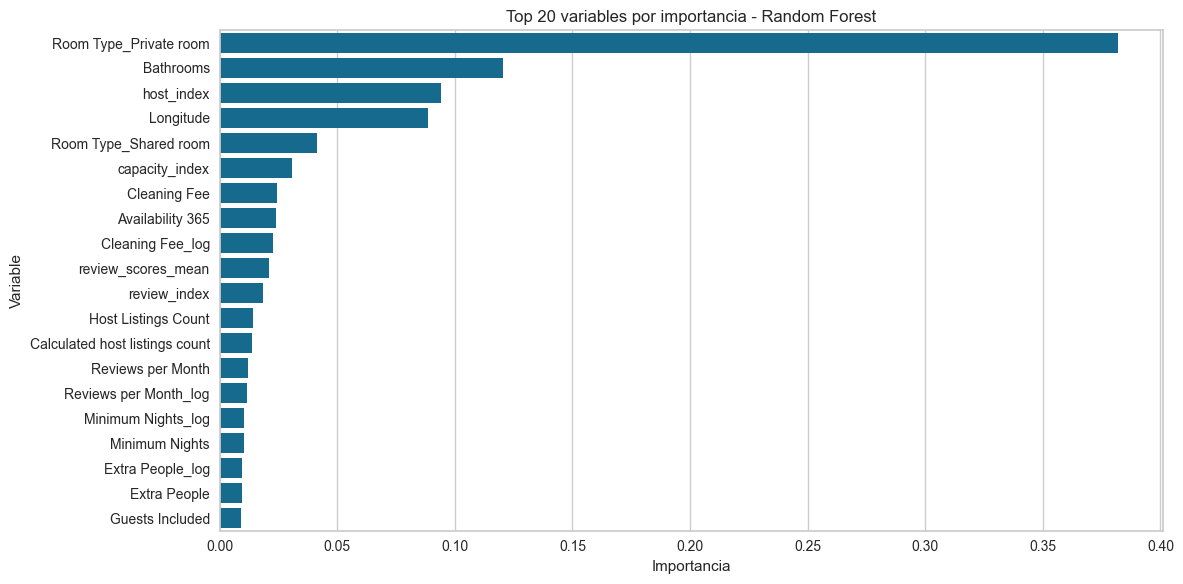

In [27]:
# Generar importancia de variables solo con las usadas en el entrenamiento
feature_importance = pd.DataFrame({
    'Variable': X_train_sel.columns,
    'Importancia': rf.feature_importances_
}).sort_values('Importancia', ascending=False)

# Visualizar top 20
plt.figure(figsize=(12, 6))
sns.barplot(x='Importancia', y='Variable', data=feature_importance.head(20))
plt.title('Top 20 variables por importancia - Random Forest')
plt.tight_layout()
plt.show()

Selección de variables importantes

In [30]:
umbral = 0.005
vars_seleccionadas = feature_importance[feature_importance['Importancia'] >= umbral]['Variable'].tolist()

X_train_sel = X_train[vars_seleccionadas]
X_test_sel = X_test[vars_seleccionadas]

print(f"Variables seleccionadas: {len(vars_seleccionadas)}")

Variables seleccionadas: 24


Evaluación del modelo

In [31]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_sel, y_train)

y_pred = rf.predict(X_test_sel)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²  : {r2:.4f}")

MAE : 0.2554
RMSE: 0.3555
R²  : 0.7369


In [32]:
# Defino modelos
modelos = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Evaluación
resultados = []

for nombre, modelo in modelos.items():
    print(f"\n Evaluando modelo: {nombre}")
    
    # Validación cruzada (CV=5)
    cv = cross_validate(
        modelo, X_train_sel, y_train,
        scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
        cv=5, return_train_score=False, n_jobs=-1
    )

    # Calcular métricas promediadas
    r2 = np.mean(cv['test_r2'])
    rmse = -np.mean(cv['test_neg_root_mean_squared_error'])
    mae = -np.mean(cv['test_neg_mean_absolute_error'])

    resultados.append({
        'Modelo': nombre,
        'R²': round(r2, 4),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2)
    })

    print(f" R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Mostrar resumen
df_resultados = pd.DataFrame(resultados).sort_values('R²', ascending=False)
display(df_resultados)


 Evaluando modelo: Linear Regression
 R²: 0.5747, RMSE: 0.45, MAE: 0.32

 Evaluando modelo: Random Forest
 R²: 0.7112, RMSE: 0.37, MAE: 0.26


,Modelo,R²,RMSE,MAE
1,Random Forest,0.7112,0.37,0.26
0,Linear Regression,0.5747,0.45,0.32


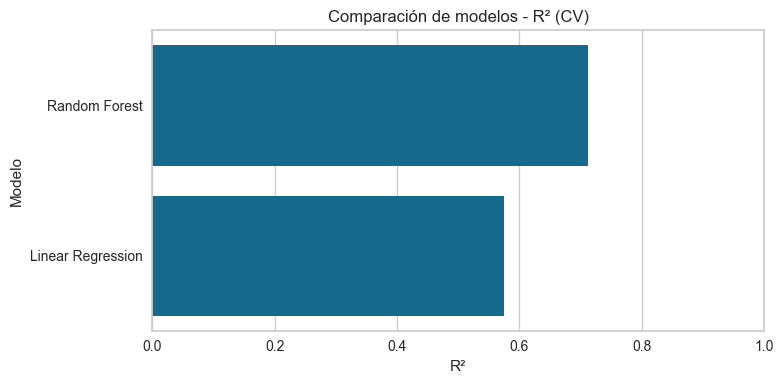

In [33]:
plt.figure(figsize=(8, 4))
sns.barplot(data=df_resultados, x='R²', y='Modelo')
plt.title("Comparación de modelos - R² (CV)")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [36]:
# Definir modelos a comparar
modelos = {
    'Baseline (Dummy)': DummyRegressor(strategy='mean'),
    'Linear Regression': LinearRegression(),
    'LassoCV': LassoCV(cv=5, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'HistGradientBoosting': HistGradientBoostingRegressor(random_state=42)
}

# Evaluación con validación cruzada
resultados = []

for nombre, modelo in modelos.items():
    print(f"\n Evaluando modelo: {nombre}")
    
    cv = cross_validate(
        modelo, X_train_sel, y_train,
        scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
        cv=5, return_train_score=False, n_jobs=-1
    )

    r2 = np.mean(cv['test_r2'])
    rmse = -np.mean(cv['test_neg_root_mean_squared_error'])
    mae = -np.mean(cv['test_neg_mean_absolute_error'])

    resultados.append({
        'Modelo': nombre,
        'R²': round(r2, 4),
        'RMSE': round(rmse, 2),
        'MAE': round(mae, 2)
    })

    print(f" R²: {r2:.4f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

# Mostrar resultados ordenados por R²
df_resultados = pd.DataFrame(resultados).sort_values('R²', ascending=False)
display(df_resultados)


 Evaluando modelo: Baseline (Dummy)
 R²: -0.0005, RMSE: 0.69, MAE: 0.55

 Evaluando modelo: Linear Regression
 R²: 0.5747, RMSE: 0.45, MAE: 0.32

 Evaluando modelo: LassoCV
 R²: 0.4297, RMSE: 0.52, MAE: 0.38

 Evaluando modelo: Random Forest
 R²: 0.7112, RMSE: 0.37, MAE: 0.26

 Evaluando modelo: HistGradientBoosting
 R²: 0.7232, RMSE: 0.36, MAE: 0.26


,Modelo,R²,RMSE,MAE
4,HistGradientBoosting,0.7232,0.36,0.26
3,Random Forest,0.7112,0.37,0.26
1,Linear Regression,0.5747,0.45,0.32
2,LassoCV,0.4297,0.52,0.38
0,Baseline (Dummy),-0.0005,0.69,0.55


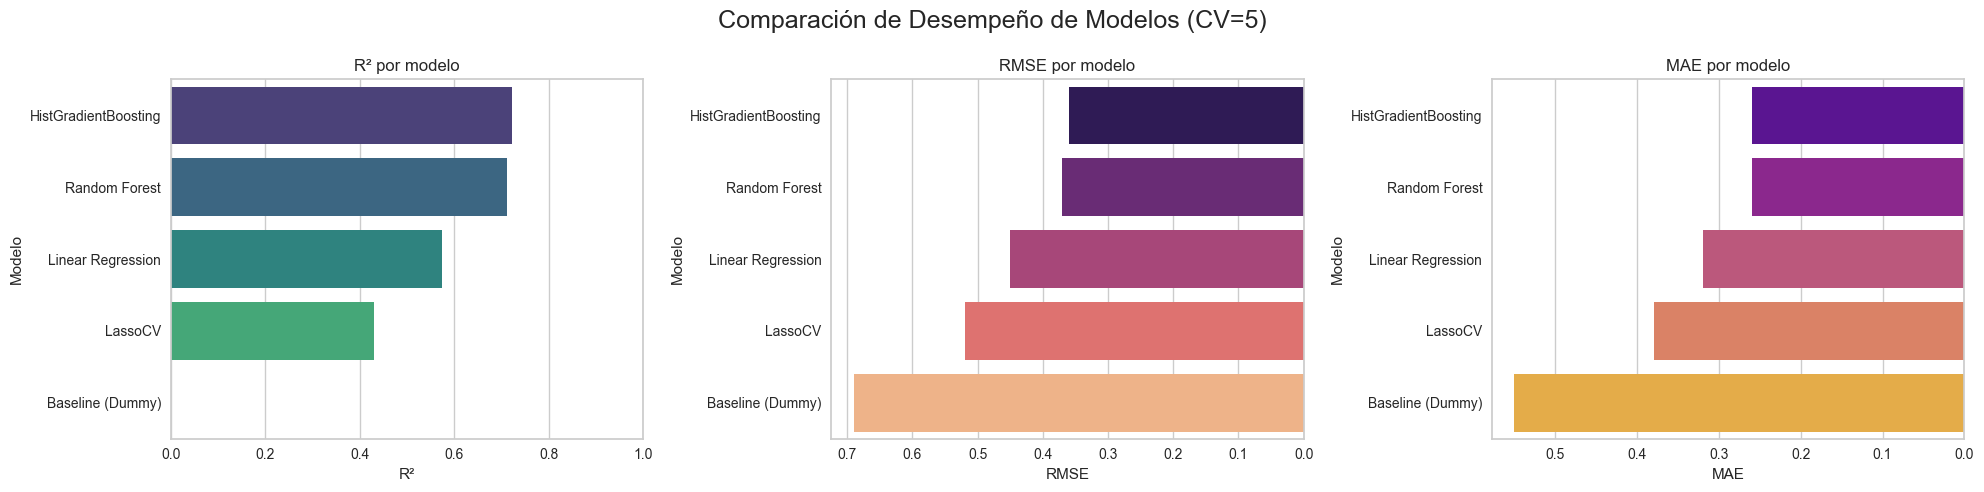

In [42]:
# Asegura el orden de modelos por desempeño (mayor R²)
df_resultados = df_resultados.sort_values(by='R²', ascending=False)

# Crear subgráficos
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# R²
sns.barplot(data=df_resultados, x='R²', y='Modelo', ax=axes[0], palette='viridis')
axes[0].set_title('R² por modelo')
axes[0].set_xlim(0, 1)

# RMSE
sns.barplot(data=df_resultados, x='RMSE', y='Modelo', ax=axes[1], palette='magma')
axes[1].set_title('RMSE por modelo')
axes[1].invert_xaxis()

# MAE
sns.barplot(data=df_resultados, x='MAE', y='Modelo', ax=axes[2], palette='plasma')
axes[2].set_title('MAE por modelo')
axes[2].invert_xaxis()

# Título general
plt.suptitle("Comparación de Desempeño de Modelos (CV=5)", fontsize=18)
plt.tight_layout()
plt.show()


R² por modelo (entre 0 y 1, más alto = mejor)
- HistGradientBoosting (0.72) y Random Forest (0.71) son los mejores.
- Ambos explican aproximadamente el 72% de la varianza del precio (Price_log).
- Linear Regression (0.57) y LassoCV (0.43) son sustancialmente peores.
- Dummy Regressor (~0) no explica nada (sirve como línea base).

RMSE (Root Mean Squared Error, más bajo = mejor)
- HistGradientBoosting tiene el RMSE más bajo (~0.36) seguido de cerca por Random Forest (~0.37).
- Linear Regression y LassoCV tienen errores significativamente mayores (~0.45 y ~0.52).
- Dummy es el peor con ~0.69.

MAE (Mean Absolute Error, más bajo = mejor)
- Nuevamente, HistGradientBoosting y Random Forest empatan (~0.26).
- Linear Regression (~0.32) y LassoCV (~0.38) son menos precisos.
- Dummy (~0.55) muestra cuánto ganan los modelos reales respecto a predecir siempre el promedio.

In [46]:
stacked = StackingRegressor(
    estimators=[
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('hgb', HistGradientBoostingRegressor(random_state=42))
    ],
    final_estimator=LinearRegression()
)

stacked.fit(X_train_sel, y_train)
y_pred_stack = stacked.predict(X_test_sel)

print("Stacked R²:", r2_score(y_test, y_pred_stack))

Stacked R²: 0.7417471417651127


El modelo StackingRegressor logró un R² de 0.7417, lo cual es:
- Mejor que cualquier modelo individual (HistGradientBoosting = 0.7232, Random Forest = 0.7112).
- Una mejora clara de 2 puntos porcentuales respecto al mejor modelo previo.
- Significa que estás explicando el 74.2% de la variabilidad del precio en la muestra de prueba.

In [47]:
mae = mean_absolute_error(y_test, y_pred_stack)
rmse = mean_squared_error(y_test, y_pred_stack, squared=False)

print(f"MAE : {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

MAE : 0.2555
RMSE: 0.3523


- El MAE en promedio, tiene un error absoluto en la escala logarítmica es 0.2555. Esto equivale a un ~29% de error relativo (exp(0.2555) ≈ 1.29).
- El RMSE error cuadrático medio es moderado y más sensible a valores extremos. Indicando una buena estabilidad.


Guardando el modelo para reutilizarlo

In [53]:
joblib.dump(stacked, "../models/final_model_stacked.pkl")

['../models/final_model_stacked.pkl']

In [54]:
# Guardando variables
vars_path = "../models/vars_seleccionadas.txt"
with open(vars_path, "w") as f:
    for col in vars_seleccionadas:
        f.write(col + "\n")

print(f"{len(vars_seleccionadas)} columnas guardadas en {vars_path}")

24 columnas guardadas en ../models/vars_seleccionadas.txt
